In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

clubs = gpd.read_file('../data/shapefiles/venues/bars_clubs/nyc_nightclubs_3627.shp')
bars = gpd.read_file('../data/shapefiles/venues/bars_clubs/nyc_bars_3627.shp')

cf_survey = gpd.read_file('../data/shapefiles/venues/creative_footprint_data.geojson')

boros = gpd.read_file('../data/shapefiles/nyc/boro_bounds.geojson')
hexagons = gpd.read_file('../data/shapefiles/nyc/hexagons.geojson')

In [2]:
clubs

,OBJECTID,id,place_id,name,lat,lng,address,price_leve,rating,type_cat,type_,type_list,sun_hours,mon_hours,tues_hours,wed_hours,thurs_hour,fri_hours,sat_hours,geometry
0,22,42389727395d845881730cbbedf9984115bcaadb,ChIJx7Ee4sf0wokR-eTKv3aXzxE,Evo,40.834470,-73.853683,"1306 Unionport Rd, Bronx, NY 10462, USA",2.0,4.0,other,night_club,"[night_club, bar, restaurant, food, point_of_i...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",POINT (312341.112 74167.472)
1,3477,5fd337dcab4d7a771a2f62c71f4158e8c920c29b,ChIJ12eHlun1wokRba529CX2qD4,The Living Room Il,40.803911,-73.919934,"125 St Ann's Ave, Bronx, NY 10454, USA",0.0,4.3,nightlife,bar,"[bar, night_club, point_of_interest, establish...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",POINT (306756.242 70766.702)
2,4401,4c508b1f1419948afafcf8cbcddf2384c80b337f,ChIJX5bU2EX0wokRMltCUVZXSmI,MAGNUS ER SEJ,40.834592,-73.906424,"Park Ave, Bronx, NY 10458, USA",0.0,0.0,other,night_club,"[night_club, point_of_interest, establishment]",None,None,None,None,None,None,None,POINT (307892.676 74174.918)
3,11258,272285ed107f959453e42265b90ddeaf6870ee01,ChIJtRFBjcH0wokRnXFBPEyknTM,Olivia's,40.832467,-73.863751,"1852 Westchester Ave, Bronx, NY 10472, USA",0.0,4.5,nightlife,bar,"[bar, night_club, restaurant, food, point_of_i...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...",POINT (311492.215 73943.592)
4,14510,b07579cbb775708aebc9c5e01ea432e5937fb92c,ChIJeQDwdbzzwokRNnv0HCHE7Uk,Parque La Carolina Ecuador,40.887003,-73.904797,"440 W 238th St, Bronx, NY 10463, USA",0.0,4.5,other,night_club,"[night_club, point_of_interest, establishment]",None,None,None,None,None,None,None,POINT (308023.545 79995.327)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,589813,3d41c65b9e0b2b185cfd022f3c15bab52ab54a29,ChIJjZlBgJNZwokRVeIhxDdROqw,Arthur's Tavern,40.733201,-74.003452,"57 Grove St, New York, NY 10014, USA",0.0,3.8,nightlife,bar,"[bar, night_club, point_of_interest, establish...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",POINT (299708.415 62911.335)
717,592802,a2cb1be508e634a81db9f6f83eb0c54f1620f13f,ChIJKRwA36pZwokRCHAL8xpjrJQ,Ortzi,40.754412,-73.985759,"120 W 41st St, New York, NY 10036, USA",3.0,4.1,nightlife,bar,"[bar, night_club, restaurant, food, point_of_i...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, ...",POINT (301202.635 65266.812)
718,593359,cd39d138075de9fed11b16d827619674b391fc0d,ChIJgwd9O6ZZwokRKKuaH

## Joining our Google Maps data with the Creative Footprint venue data

* We'd like to get all **unique bars and clubs from Google**, merge it with the **Creative Footprint venue data**, **deduplicate** the resulting merged frame, and then aggregate by **spatial joining into hexbins**.

In [3]:
google_maps = pd.concat([clubs, bars])\
                .drop_duplicates(subset='name', keep='first')\
                .sort_values('name')\
                .reset_index(drop=True)
            
print(f"There are {clubs.name.size} total clubs in the Google Maps data.")
print(f"There are {bars.name.size} total bars in the Google Maps data.")
print(f"There are {google_maps.name.size} total nightlife venues in the Google Maps data.")

google_maps.sort_values('name')[['name', 'address']].head(3)

There are 721 total clubs in the Google Maps data.
There are 3475 total bars in the Google Maps data.
There are 3601 total nightlife venues in the Google Maps data.


,name,address
0,$3 Bill,"260 Meserole St, Brooklyn, NY 11206, USA"
1,(formerly) L’Amours,"1546 62nd St, Brooklyn, NY 11219, USA"
2,1 Oak,"453 W 17th St, New York, NY 10011, USA"


In [4]:
cf_venues = [x.lower() for x in cf_survey.Name]
goog_venues = [x.lower() for x in google_maps.name]
common_venues = sorted(list(set(goog_venues) & set(cf_venues)))

print(f"The datasets have {len(common_venues)} venues in common.")
print(common_venues[:5])

The datasets have 95 venues in common.
['1 oak', '310 bowery bar', '55 bar', "alfie's place", "arlene's grocery"]


In [5]:
cf_survey['Name'] = cf_survey['Name'].str.lower()
cf_shared = cf_survey[cf_survey['Name'].isin(common_venues)]

merged = cf_survey.merge(cf_shared, indicator=True, how='outer')
cf_unique = merged[merged['_merge'] == 'left_only']

print(f"There are {len(cf_unique)} venues unique to the Creative Footprint data.")

There are 400 venues unique to the Creative Footprint data.


In [6]:
sel_features = ['Name', 'Street', 'Zip', 'City', 'geometry']
cf_unique = cf_unique[sel_features] # filter records

cf_unique.columns = map(str.lower, cf_unique.columns) # columns to lowercase

cf_unique['address'] = cf_unique.agg(lambda x: f"{x['street']}, {x['city']}, {x['zip']}", axis=1)

cf_unique = cf_unique[['name', 'address', 'geometry']]
cf_unique = cf_unique.to_crs(epsg=3627) # reproject
cf_unique.head(3)

,name,address,geometry
0,983,"983 Flushing Avenue, New York, 11206",POINT (305628.461 59570.774)
2,1040 metropolitan,"1040 Metropolitan Ave, New York, 11211",POINT (305517.844 60806.767)
3,1896 studio & stages,"215 Ingraham St, New York, 11237",POINT (306362.838 60192.683)


In [7]:
sel_features = ['name', 'address', 'geometry']
google_maps = google_maps[sel_features]
google_maps.head(3)

,name,address,geometry
0,$3 Bill,"260 Meserole St, Brooklyn, NY 11206, USA",POINT (305207.331 60160.542)
1,(formerly) L’Amours,"1546 62nd St, Brooklyn, NY 11219, USA",POINT (300479.004 50788.507)
2,1 Oak,"453 W 17th St, New York, NY 10011, USA",POINT (299473.613 64101.910)


,name,address,geometry
0,$3 Bill,"260 Meserole St, Brooklyn, NY 11206, USA",POINT (305207.331 60160.542)
1,(Formerly) L’Amours,"1546 62nd St, Brooklyn, NY 11219, USA",POINT (300479.004 50788.507)
2,1 Oak,"453 W 17th St, New York, NY 10011, USA",POINT (299473.613 64101.910)
3,1 Pike Cafe & Bar,"1 Pike Street #B, New York, NY 10002, USA",POINT (300641.706 60809.991)
4,1 Rooftop,"60 Furman St, Brooklyn, NY 11201, USA",POINT (300368.898 59463.759)


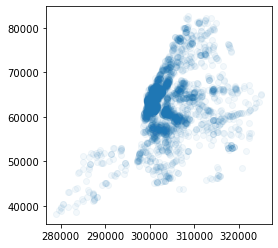

In [8]:
joined_venues = pd.concat([cf_unique, google_maps]).sort_values('name')
joined_venues['name'] = joined_venues['name'].str.title() # titlecase names

joined_venues.plot(alpha=0.05);
joined_venues.head()

### Plot on hexgrid

In [9]:
sjoined_hexes = gpd.sjoin(hexagons, joined_venues)

venue_count = sjoined_hexes['hex_id_8'].value_counts().reset_index()

venue_count.rename(columns={'index':'hex_id_8', 'hex_id_8':'count'}, inplace=True)

gdf = pd.merge(hexagons,
               venue_count,
               how='left',
               on=['hex_id_8'])\
        .fillna(0)\
        .sort_values('count', ascending=False)
    
gdf.head(3)

,hex_id_8,geometry,count
1165,882a100d65fffff,"POLYGON ((301714.781 65863.222, 301880.715 663...",144.0
1193,882a1072cbfffff,"POLYGON ((300594.554 61028.530, 301133.174 611...",136.0
1129,882a100d2dfffff,"POLYGON ((301010.106 65250.815, 300471.361 651...",110.0


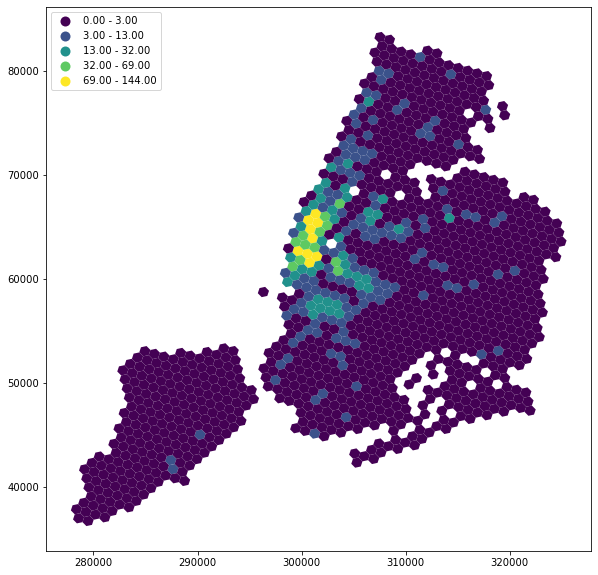

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

gdf.plot(column='count',
         ax=ax,
         scheme='fisher_jenks',
         legend=True,
         legend_kwds={'loc': 'upper left'});

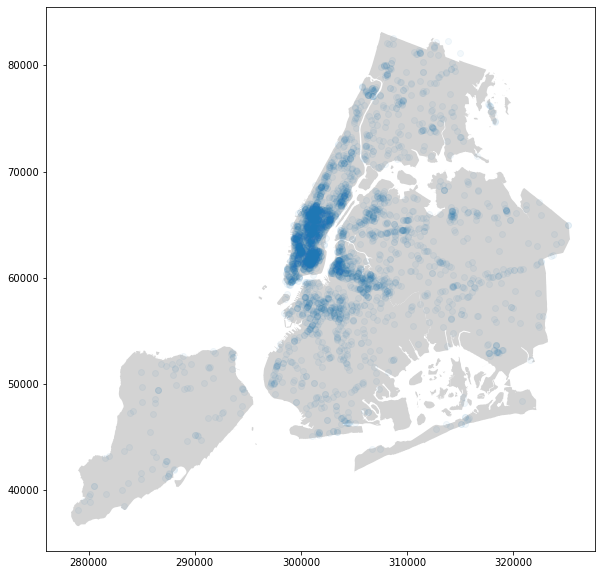

In [11]:
boros = boros.to_crs(epsg=3627)
base = boros.plot(figsize=(10,10), color='lightgrey')

joined_venues.plot(ax=base, alpha=0.05);

In [12]:
# desired format:
# hexbin | taxi pickups, taxi dropoffs, bike pickups, bike dropoffs

In [15]:
gdf.head(3)

,hex_id_8,geometry,count
1165,882a100d65fffff,"POLYGON ((301714.781 65863.222, 301880.715 663...",144.0
1193,882a1072cbfffff,"POLYGON ((300594.554 61028.530, 301133.174 611...",136.0
1129,882a100d2dfffff,"POLYGON ((301010.106 65250.815, 300471.361 651...",110.0


In [16]:
gdf.to_file("../data/shapefiles/nyc/venues_hexbinned.geojson",
            driver='GeoJSON')